In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Lambda, Conv2D,MaxPooling2D, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train_normed = x_train / 255.0
x_test_normed = x_test / 255.0


In [4]:
y_test.shape

(10000,)

In [5]:
y_train[y_train == 1].shape

(6000,)

In [6]:
np.where(y_train == 1)[0].shape

(6000,)

In [7]:
indexes = np.where(y_train == 1)[0]

In [8]:
np.random.choice(indexes.shape[0], replace = False)

4819

In [9]:
indexes = np.arange(10)
even_indexes = indexes[indexes % 2 == 0]
print(even_indexes)

[0 2 4 6 8]


In [10]:
def create_dataset_pairs(n_classes, labels):
  #even = same , same = 1
  pairs = []
  pairs_label = []
  for i in range(n_classes):
    class_indexes = np.where(labels == i)[0]
    not_class_indexes = np.where(labels != i)[0]
    not_class_indexes = np.random.choice(not_class_indexes, class_indexes.shape[0], replace=False)
    class_indexes_shuffled = class_indexes.copy()
    np.random.shuffle(class_indexes_shuffled)
    np.random.shuffle(not_class_indexes)
    indexes = np.arange(2 * class_indexes.shape[0])
    arr = np.zeros(shape=(2 * class_indexes.shape[0], 2),dtype='int')
    arr[np.where(indexes % 2 == 0), 0] = class_indexes
    arr[np.where(indexes % 2 == 0), 1] = class_indexes_shuffled
    arr[np.where(indexes % 2 == 1), 0] = class_indexes
    arr[np.where(indexes % 2 == 1), 1] = not_class_indexes
    pair_label = indexes % 2 == 0
    # print(pair_label)
    pair_label = np.array(pair_label, dtype='int')
    pairs_label.append(pair_label)
    pairs.append(arr)
  pairs = np.vstack(pairs)
  pairs_label = np.concatenate(pairs_label)
  return pairs, pairs_label

In [11]:
tr_pairs, tr_labels = create_dataset_pairs(10, y_train)
ts_pairs, ts_labels = create_dataset_pairs(10,y_test)

In [12]:
ts_labels.shape

(20000,)

In [13]:
np.random.choice(5, 5)

array([3, 3, 0, 2, 4])

In [14]:
np.random.choice([100,200,33], 2)

array([100,  33])

In [15]:
def show_pair(pairs,ind):
  act_ind = int(pairs[ind,0])
  plt.imshow(x_train[act_ind,:,:],cmap='gray')
  plt.show()
  print(y_train[act_ind])
  act_ind = int(pairs[ind,1])
  plt.imshow(x_train[act_ind,:,:],cmap='gray')
  plt.show()
  print(y_train[act_ind])

In [ ]:
for i in range(5):
  show_pair(tr_pairs,i)

In [17]:
epsilon = 1e-7
def euclidean_distance(x):
  x1,x2 = x
  sum = tf.reduce_sum(tf.math.square(x1 - x2), axis=1, keepdims = True)
  return tf.math.maximum(sum,epsilon)

def euclidean_distance_shape(s):
  shape1, shape2 = s
  return (shape1[0], 1)

def get_model():
  def get_base_model():
    input = Input(shape=(28, 28,1))
    x = input
    x = Conv2D(32, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    model = Model(inputs = input, outputs = x)
    return model
  input1 = Input(shape=(28, 28,1))
  input2 = Input(shape=(28, 28,1))
  base_model = get_base_model()
  out1 = base_model(input1)
  out2 = base_model(input2)
  out = Lambda(euclidean_distance,euclidean_distance_shape)([out1, out2])
  model = Model(inputs = [input1, input2], outputs = out)
  return model

  

In [18]:
x_train_expanded = np.expand_dims(x_train_normed, axis = -1)
x_test_expanded = np.expand_dims(x_test_normed, axis = -1)

In [19]:
def contrastive_loss(margin):
  def loss(y_true, y_pred):
    # loss = Y * Ypred^2 + (1 - Y) * (max(margin - Ypred))^2
    squared = tf.math.square(y_pred)
    margin_squared = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean(y_pred * squared + (margin - y_pred) * margin_squared)
  return loss


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          109184      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

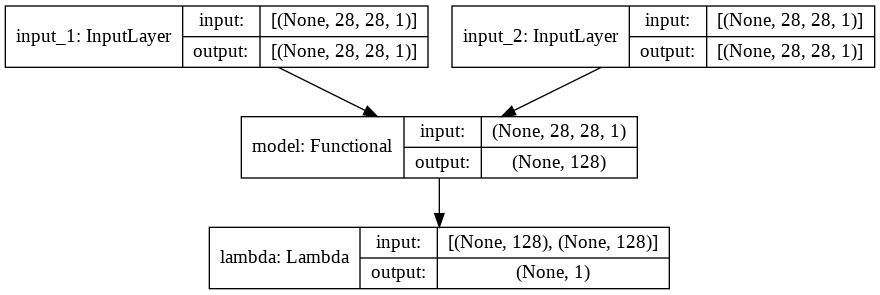

In [20]:
model = get_model()
model.summary()
plot_model(model,show_shapes=True)

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=.01)
model.compile(optimizer=optimizer, loss=contrastive_loss(1))

In [22]:
model.fit(x = (x_train_expanded[tr_pairs[:,0]],x_train_expanded[tr_pairs[:,1]]), y = tr_labels, epochs=20, batch_size=128, validation_data=((x_test_expanded[ts_pairs[:,0]],x_test_expanded[ts_pairs[:,1]]),ts_labels))

Epoch 1/20
938/938 [==============================] - 42s 9ms/step - loss: 0.5062 - val_loss: 0.3554
Epoch 2/20
938/938 [==============================] - 8s 9ms/step - loss: 0.3430 - val_loss: 0.3263
Epoch 3/20
938/938 [==============================] - 8s 9ms/step - loss: 0.3168 - val_loss: 0.3072
Epoch 4/20
938/938 [==============================] - 8s 9ms/step - loss: 0.3052 - val_loss: 0.2985
Epoch 5/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2976 - val_loss: 0.2966
Epoch 6/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2929 - val_loss: 0.3005
Epoch 7/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2895 - val_loss: 0.2938
Epoch 8/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2870 - val_loss: 0.2868
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2848 - val_loss: 0.2900
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.2833 - val_loss: 0.289

In [24]:
model.save('/content/model.h5')

In [27]:
model = tf.keras.models.load_model('/content/model.h5',custom_objects={'loss':contrastive_loss(1)})

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          109184      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [68]:
random_ind_train = np.random.choice(tr_pairs.shape[0], 20)
random_ind_test = np.random.choice(ts_pairs.shape[0], 20)

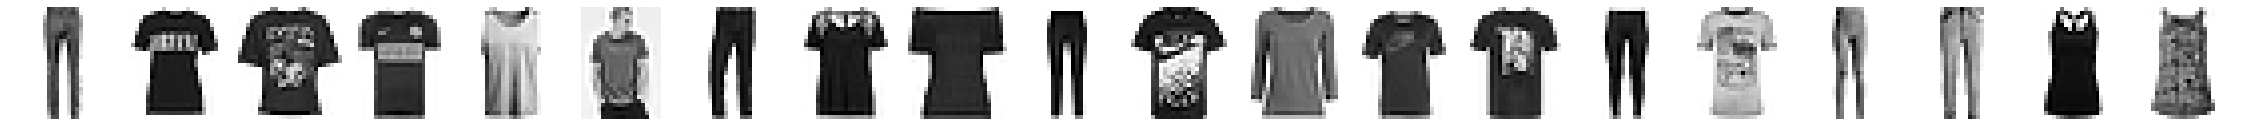

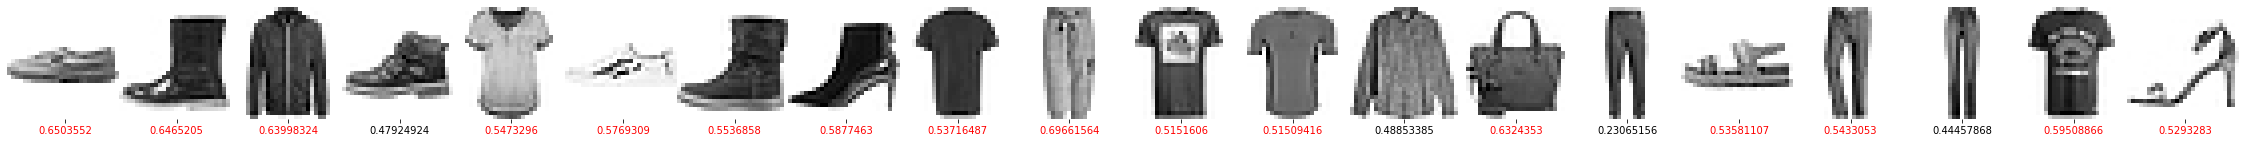

In [69]:
def show_pair_predicted(indexes, threshold,width_multiplier = 2,test = False):
  plt.figure(figsize=(width_multiplier * len(indexes),3))
  plt.box(None)
  cont = np.concatenate(x_train[tr_pairs[indexes,0]],axis=1) * 255.0
  plt.imshow(cont,cmap='gray_r')
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.figure(figsize=(width_multiplier * len(indexes),3))
  plt.box(None)
  cont = np.concatenate(x_train[tr_pairs[indexes,1]],axis=1) * 255.0
  plt.imshow(cont,cmap='gray_r')
  plt.yticks([])
  if test:
    img_pairs = (x_test_expanded[ tr_pairs[indexes,0] ],x_test_expanded[ tr_pairs[indexes,1] ])
  else:
    img_pairs = (x_train_expanded[ tr_pairs[indexes,0] ],x_train_expanded[ tr_pairs[indexes,1] ])
  predictions = model.predict(x = img_pairs)
  # print(predictions)
  plt.xticks([28*i+14 for i in range(len(indexes))],np.squeeze(predictions))
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if(predictions[i] > threshold):
      t.set_color('red')
  plt.show()
show_pair_predicted(random_ind_test,.5,2)